MPDATA import

In [1]:
from MPyDATA.arakawa_c.scalar_field import ScalarField
from MPyDATA.arakawa_c.vector_field import VectorField
from MPyDATA.arakawa_c.boundary_condition.cyclic import Cyclic
import numpy as np
import matplotlib.pyplot as plt

Auxiliary functions import

           

In [2]:
from aux_one_dim import grad, extrapolate_in_time, interpolate_in_space

Advectee and advector initialization

In [3]:
dx = 0.8
dt = 0.1

In [4]:
from MPyDATA.options import Options
options = Options(n_iters=2, infinite_gauge=True, flux_corrected_transport=True)

nx = 20

initial_m_value = 0.2

h_initial = np.full(nx, initial_m_value)

h_initial[8] = 0.3

h_old = np.array(h_initial)
h_new = np.array(h_initial)
uh_old = np.array(h_initial)
uh_new = np.array(h_initial)


# TODO: to nie jest u, tylko Courant number C=u*dt/dx
u_initial = np.zeros((nx + 1))

u_old = np.array(u_initial)
u_new = np.array(u_initial)

rhs_old = np.array(h_old)

halo = options.n_halo

advectee = ScalarField(
    data = h_new,
    halo=halo, 
    boundary_conditions=(Cyclic(), )
)

advector = VectorField(
    data = (u_initial,),
    halo=halo,
    boundary_conditions=(Cyclic(), )   
)

print('h_new', h_new)
print()
print('u_new', u_initial)
print()
print('grad', grad(h_new))  # TODO

h_new [0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.3 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2
 0.2 0.2]

u_new [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

grad [ 0.    0.    0.    0.    0.    0.    0.    0.05  0.   -0.05  0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.  ]


Stepper setup

In [5]:
from MPyDATA.stepper import Stepper
stepper = Stepper(options=options, grid=(nx,))

from MPyDATA.solver import Solver
solver = Solver(stepper=stepper, advectee=advectee, advector=advector)

Initial state

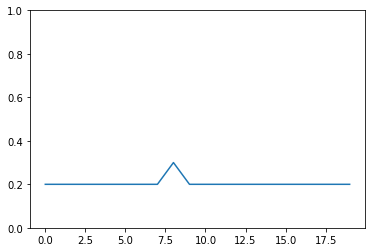

In [6]:
# plt.imshow(h_new, cmap='hot', interpolation='nearest')
axes = plt.gca()
# axes.set_xlim([xmin,xmax])
axes.set_ylim([0.,1.])

plt.plot(h_new, '-')
plt.show()

Main loop

In [7]:
def MPDATA(advector, advectee):
    solver.curr.get()[:] = advectee
    solver.GC_phys.get_component(0)[:] = advector
    solver.advance(nt=1)
    return solver.curr.get() 

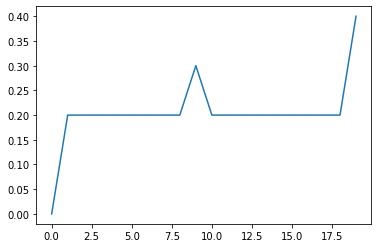

/home/white/study/cm/project/shallow-water/aux_one_dim.py:19: RuntimeWarning: divide by zero encountered in true_divide
  result = np.where(h > 0, uh/h, 0.)


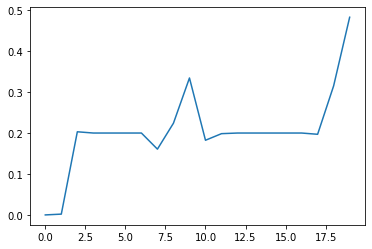

/home/white/study/cm/project/shallow-water/aux_one_dim.py:19: RuntimeWarning: divide by zero encountered in true_divide
  result = np.where(h > 0, uh/h, 0.)


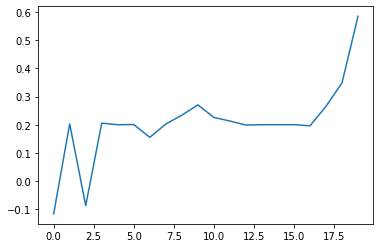

/home/white/study/cm/project/shallow-water/aux_one_dim.py:19: RuntimeWarning: divide by zero encountered in true_divide
  result = np.where(h > 0, uh/h, 0.)


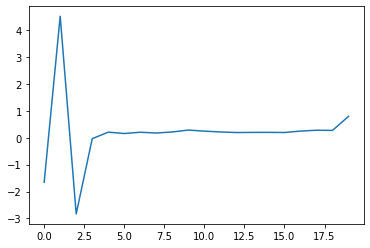

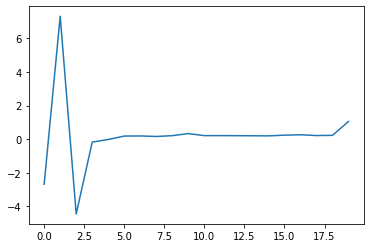

In [8]:
g = 9.8 # m/s^2
for _ in range(5):
    u_mid = extrapolate_in_time(interpolate_in_space(uh_new, h_new), interpolate_in_space(uh_old, h_old))
#     print('u_mid', u_mid)
    
    #RHS = 0, mass conservation
    h_new[:] = MPDATA(u_mid, h_old)
    
    
    # -h * grad(h)   
    rhs_new = -g *  h_new * grad(h_new, dx=dx)
    

    #momentum conservation
    uh_new[:] = MPDATA(u_mid, uh_old + .5 * dt * rhs_old) + .5 * dt * rhs_new
    
    
    plt.plot(h_new, '-')
    plt.show()
    
    # replace variables
    h_old, h_new = h_new, h_old
    u_old, u_new = u_new, u_old
    rhs_old, rhs_new = rhs_new, rhs_old

#     h_old[:] = h_new
#     rhs_old[:] = rhs_new
#     u_old[:] = u_new
    